In [7]:
from music21 import converter, instrument, clef, stream, analysis, midi, stream, note
from plotters import saveToMidi, plotBoundaryStrength
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

identifier = "beethoven-op67"
path = f"../Pickles/{identifier}/{identifier}_"

score = converter.parse(path + "score.musicxml")

In [ ]:
def pitchDegree(n1: note.Note, n2: note.Note) -> float:
    return abs(n1.pitch.ps - n2.pitch.ps) / (n1.pitch.ps + n2.pitch.ps)

def offsetDegree(n1: note.Note, n2: note.Note, stream: stream.Stream) -> float:
    return abs(n1.getOffsetInHierarchy(stream) - n2.getOffsetInHierarchy(stream)) / (n1.getOffsetInHierarchy(stream) + n2.getOffsetInHierarchy(stream))

def normalise(data: np.array) -> np.array:
    return (data - np.min(data)) / (np.max(data) - np.min(data))

def calculateStrengths(stream: stream.Stream, weights: tuple[float]) -> tuple[pd.DataFrame, float]:
    '''
    Returns a table of calculate boundary strengths.
    '''

    df = pd.DataFrame()
    noteStream = stream.flatten().notes

    for n in noteStream:

        offset = n.offset
        # If chord use the top note
        if hasattr(n, "notes"):
            n = n.notes[-1]

        pitch = n.pitch.ps
        
        new_row = pd.DataFrame({
            "Pitch": [pitch],
            "Offset": [offset]
            })

        df = pd.concat([df, new_row])

    degreeOfChange = lambda x1, x2 : abs(x1 - x2) / (x1 + x2)
    strength = lambda x1, x2, x3 : x2 * (degreeOfChange(x1, x2) + degreeOfChange(x2, x3))

    df["Pitch strength"] = normalise(np.array(
        [0] +
        [strength(df["Pitch"].iloc[i-1], df["Pitch"].iloc[i], df["Pitch"].iloc[i+1]) for i in range(1, len(df["Pitch"])-1)] +
        [0]))
    
    df["Offset strength"] = normalise(np.array(
        [0] +
        [strength(df["Offset"].iloc[i-1], df["Offset"].iloc[i], df["Offset"].iloc[i+1]) for i in range(1, len(df["Offset"])-1)] +
        [0]))

    df.eval("Strength = @weights[0]*`Pitch strength` + @weights[1]*`Offset strength`", inplace=True)

    threshold = df["Strength"].max() / 4
    df.eval("IsBoundary = Strength >= @threshold", inplace=True)

    return df, threshold

   Pitch  Offset  Pitch strength  Offset strength  Strength  IsBoundary
0   43.0     0.5        0.000000         0.000000  0.000000       False
0   43.0     1.0        0.000000         0.048227  0.031830       False
0   43.0     1.5        0.139837         0.046505  0.076839       False
0   39.0     2.0        0.191829         0.095394  0.126264       False
0   41.0     4.5        0.068333         0.177922  0.139979       False


Text(0, 0.5, 'Boundary strength')

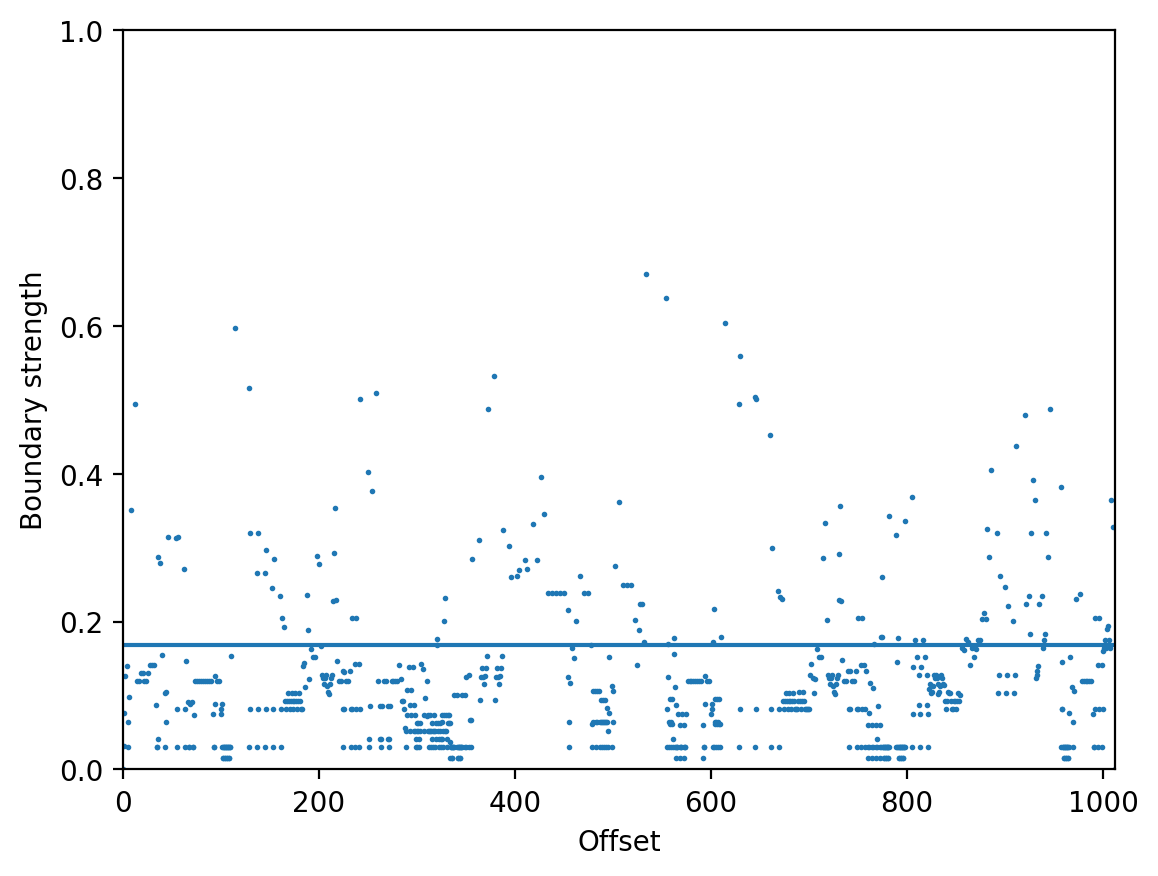

In [110]:
#score = converter.parse(path + "score.musicxml")

df, threshold = calculateStrengths(score.parts[-2], (0.33,0.66))

print(df.head())

plt.scatter(df["Offset"], df["Strength"], s=1)
plt.hlines(threshold, 0, df["Offset"].max())

plt.xlim(0, df["Offset"].max())
plt.ylim(0,1)
plt.xlabel("Offset")
plt.ylabel("Boundary strength")

#saveToMidi(score, "../67-edited.mid")
#score.write(fmt="musicxml", fp=f"../beethoven-op67.musicxml")

# TODO: Check what MIDI sounds like after arrangement (transposing instruments etc.)

In [ ]:
# TODO: Save phrases within a stream (instead of pickle)

bassoon = instrument.Bassoon()
print(bassoon.lowestNote.ps, bassoon.highestNote)

toy = converter.parse("tinyNotation: 4/4 r8 d' d' d' g' a' b' a' g2 r")

def shiftOctave(s: stream.Stream, o: int):
    for n in s.recurse().notes:
        n.octave += o

p = analysis.discrete.Ambitus()
pitchMin, pitchMax = p.getPitchSpan(toy)
print(pitchMin)

shiftOctave(toy, -2)
toy.show()

sp = midi.realtime.StreamPlayer(toy)
sp.play()

print(pitchMin)

In [22]:
score.write(fmt="musicxml", fp=f"../raiders")

musicxml.m21ToXml: WARNING: we are out of midi channels! help!


WindowsPath('c:/Users/Lucas/OneDrive - Durham University/PHYS4213/raiders.musicxml')

In [ ]:
score = converter.parse("../Pickles/Beethoven/Beethoven_score.musicxml")
#saveToMidi(score, "../Pickles/Beethoven/beethoven.mid")

new = stream.Score()

for part in score.parts:

    print(part.partName)
    part.atSoundingPitch = True
    print(part.atSoundingPitch)

    voices = part.voicesToParts()
    print(len(voices.parts))
    if len(voices.parts) > 1:
        part = part.voicesToParts().parts[0]

    new.append(part)

new.measures(1,7).show()
saveToMidi(new, "../Pickles/Beethoven/sounding_pitch.mid")
#new.write(fmt="musicxml", fp=f"../Pickles/Beethoven/beethoven.musicxml")

In [ ]:
saveToMidi(new, "../Pickles/Beethoven/beethoven.mid")

In [ ]:
print(len(score.parts[2].voices))
cl = score.parts[2].voicesToParts()
vl = score.parts[8].voicesToParts()
print(len(cl.parts))
print(len(vl.parts))
#score.show("text")
#cl.show("text")

#saveToMidi(cl, "../Pickles/Beethoven/cl.mid")

In [ ]:
score.flatten().notes.stream().show("midi")